## 루브릭

#### 1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
 - 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였는가? (O) <br/>
 
#### 2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
 - 제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가? (△)<br/>
 
#### 3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
 - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻는가?(O)<br/>

# EDA

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [4]:
target = train['price']
del train['price']

 - price는 타겟값이기에 test데이터에는 없으므로 target에 저장 후 제거

In [20]:
data = pd.concat((train, test), axis=0)
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,NaN,3,1.75,1500,11968,1.0,0,0,...,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,NaN,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,NaN,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,NaN,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


탐색용으로 data값에 train과 test값 합침

### 결측치 확인

<AxesSubplot:>

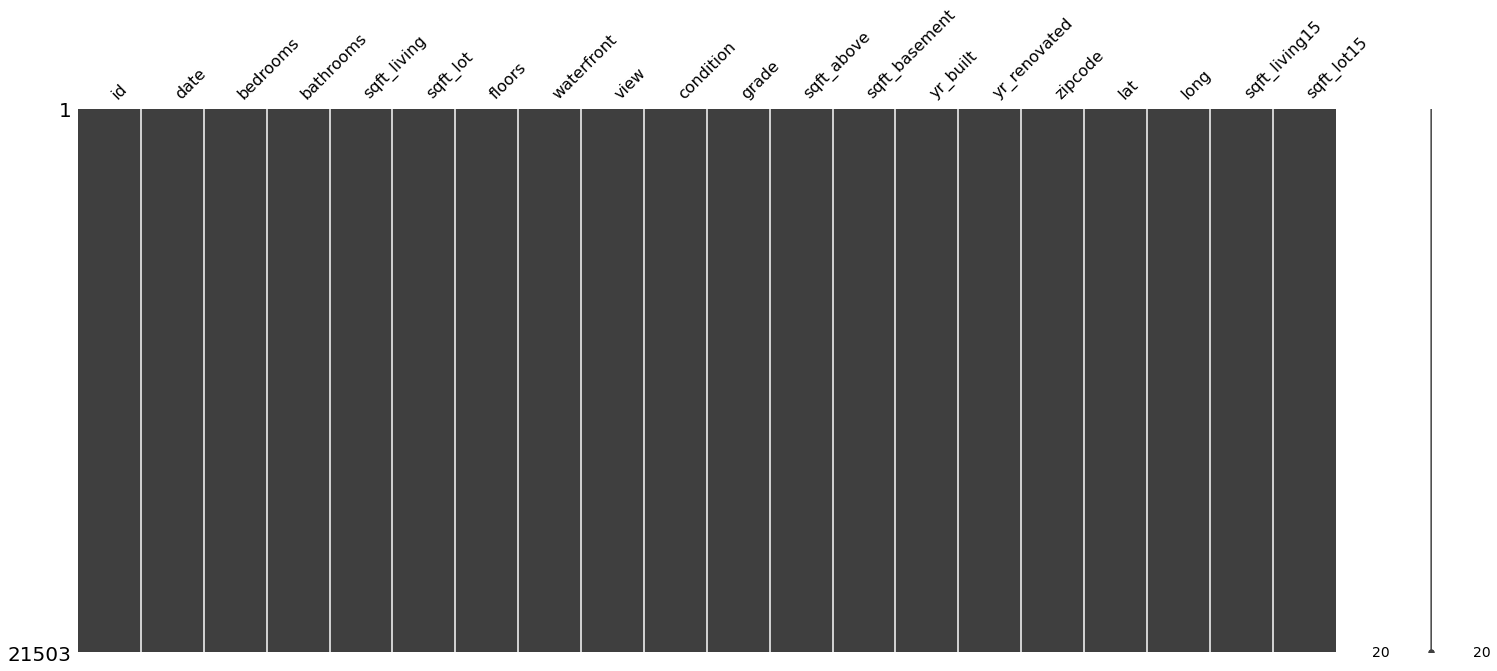

In [10]:
msno.matrix(data)

결측치가 있으면 하얀 실선이 나타나게 된다.
없으므로 결측치는 없는 것으로 간주<br/>
<br/>

 - 결측치 출력하여 확인

In [11]:
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [37]:
d_id = data['id'][len(train):]
del data['id']

 - id는 학습할때는 필요가 없기에 제외하여 d_id에 저장 후 예측결과 제출에 사용

In [38]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


 - data의 뒷부분은 모두 0으로 동일하기에 제거

<AxesSubplot:xlabel='price', ylabel='Count'>

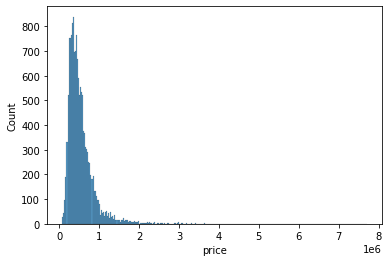

In [61]:
sns.histplot(data=target)

- target인 Price는 왼쪽으로 치우쳐져있기에 훈련시킬때 log 변환을 시킨다.

In [64]:
target = np.log1p(target)

<AxesSubplot:xlabel='price', ylabel='Count'>

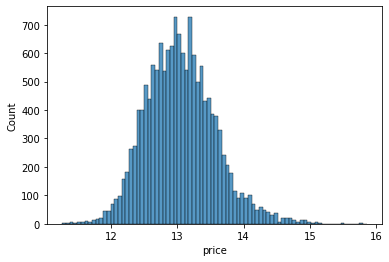

In [65]:
sns.histplot(data=target)

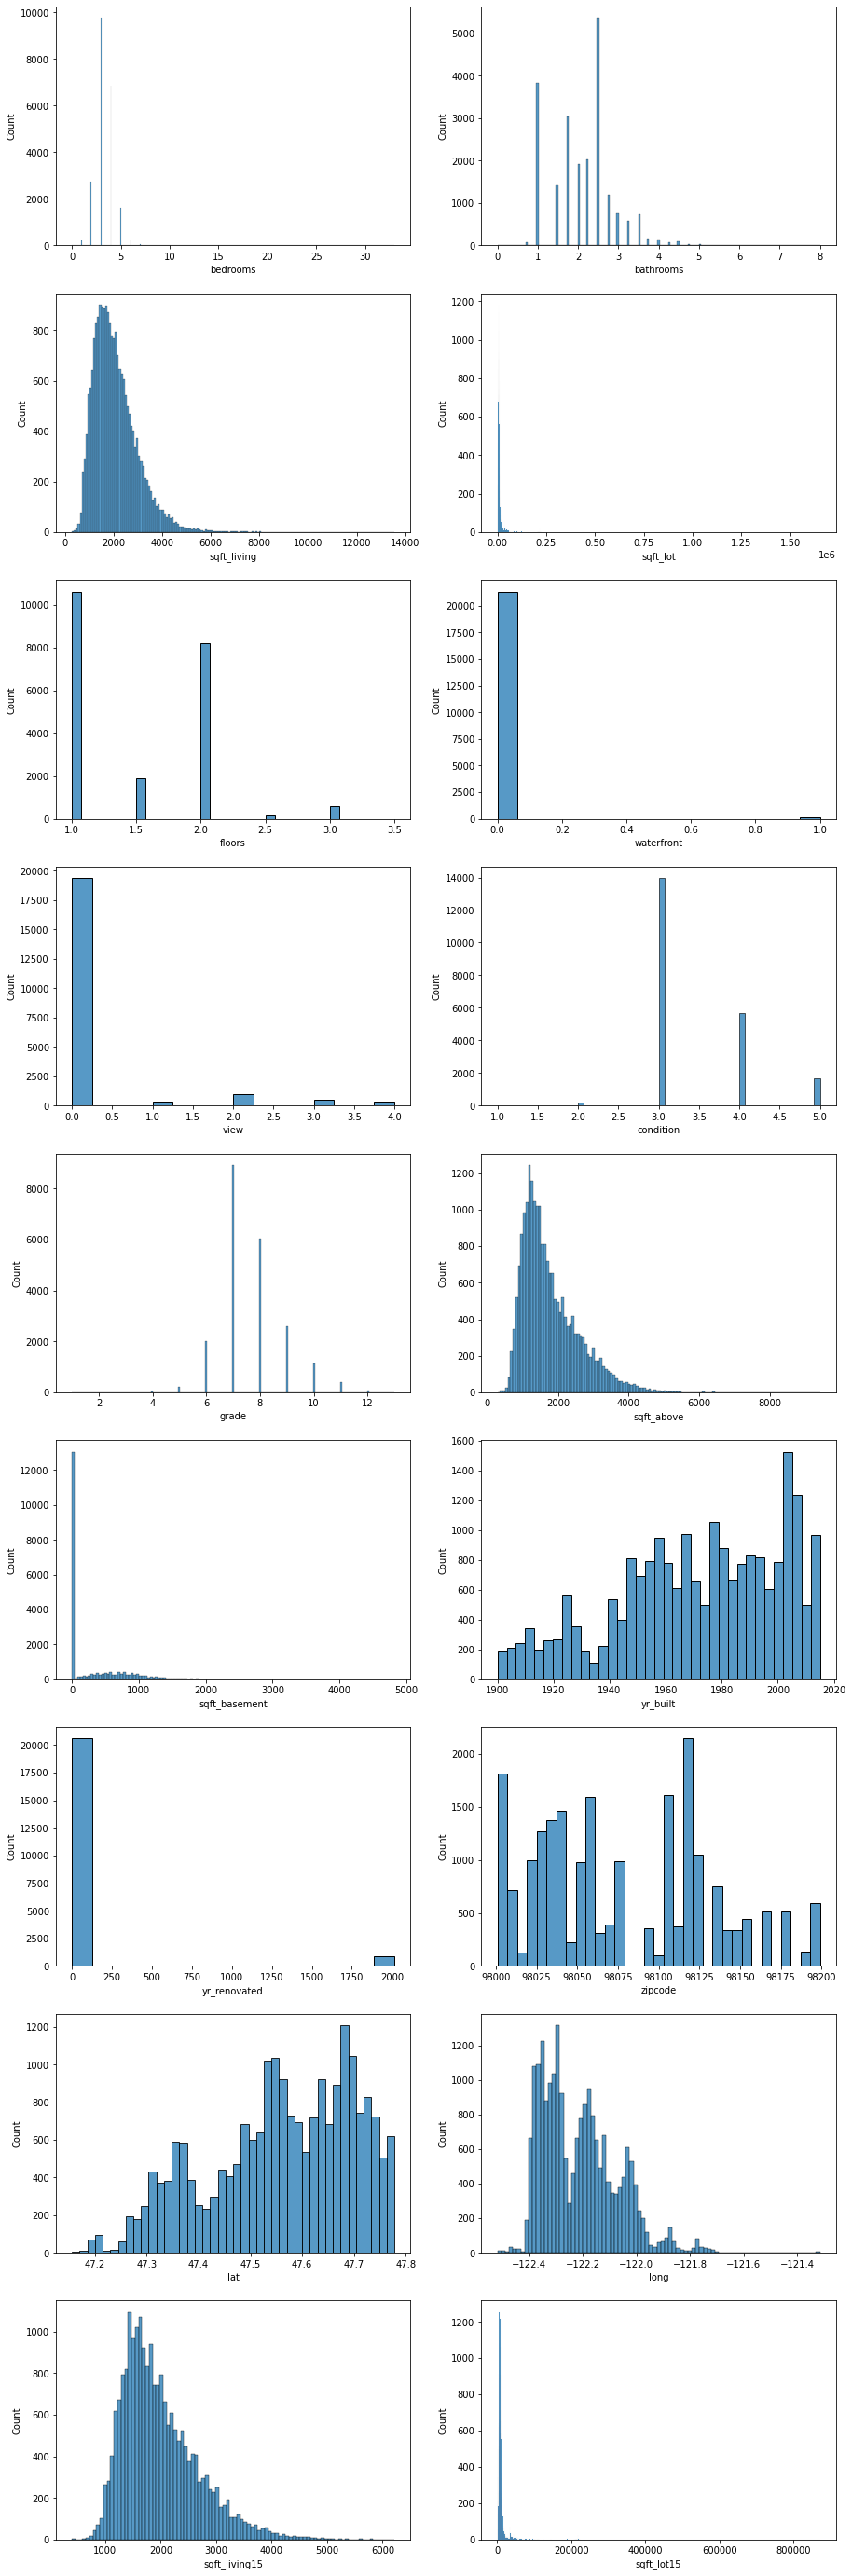

In [26]:
fig, ax = plt.subplots(9, 2, figsize=(15,50))
count = 1


for i in range(9):
    for j in range(2):
        sns.histplot(data=data[data.columns[count]], ax=ax[i][j])
        count +=1
        if count == 19 :
            break

 - bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, 'qft_lot15, sqft_living15 가 좌로 치우쳐져있다고 판단하여 로그변환을 하려한다.

In [39]:
a = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for i in a:
    data[i] = np.log1p(data[i].values)

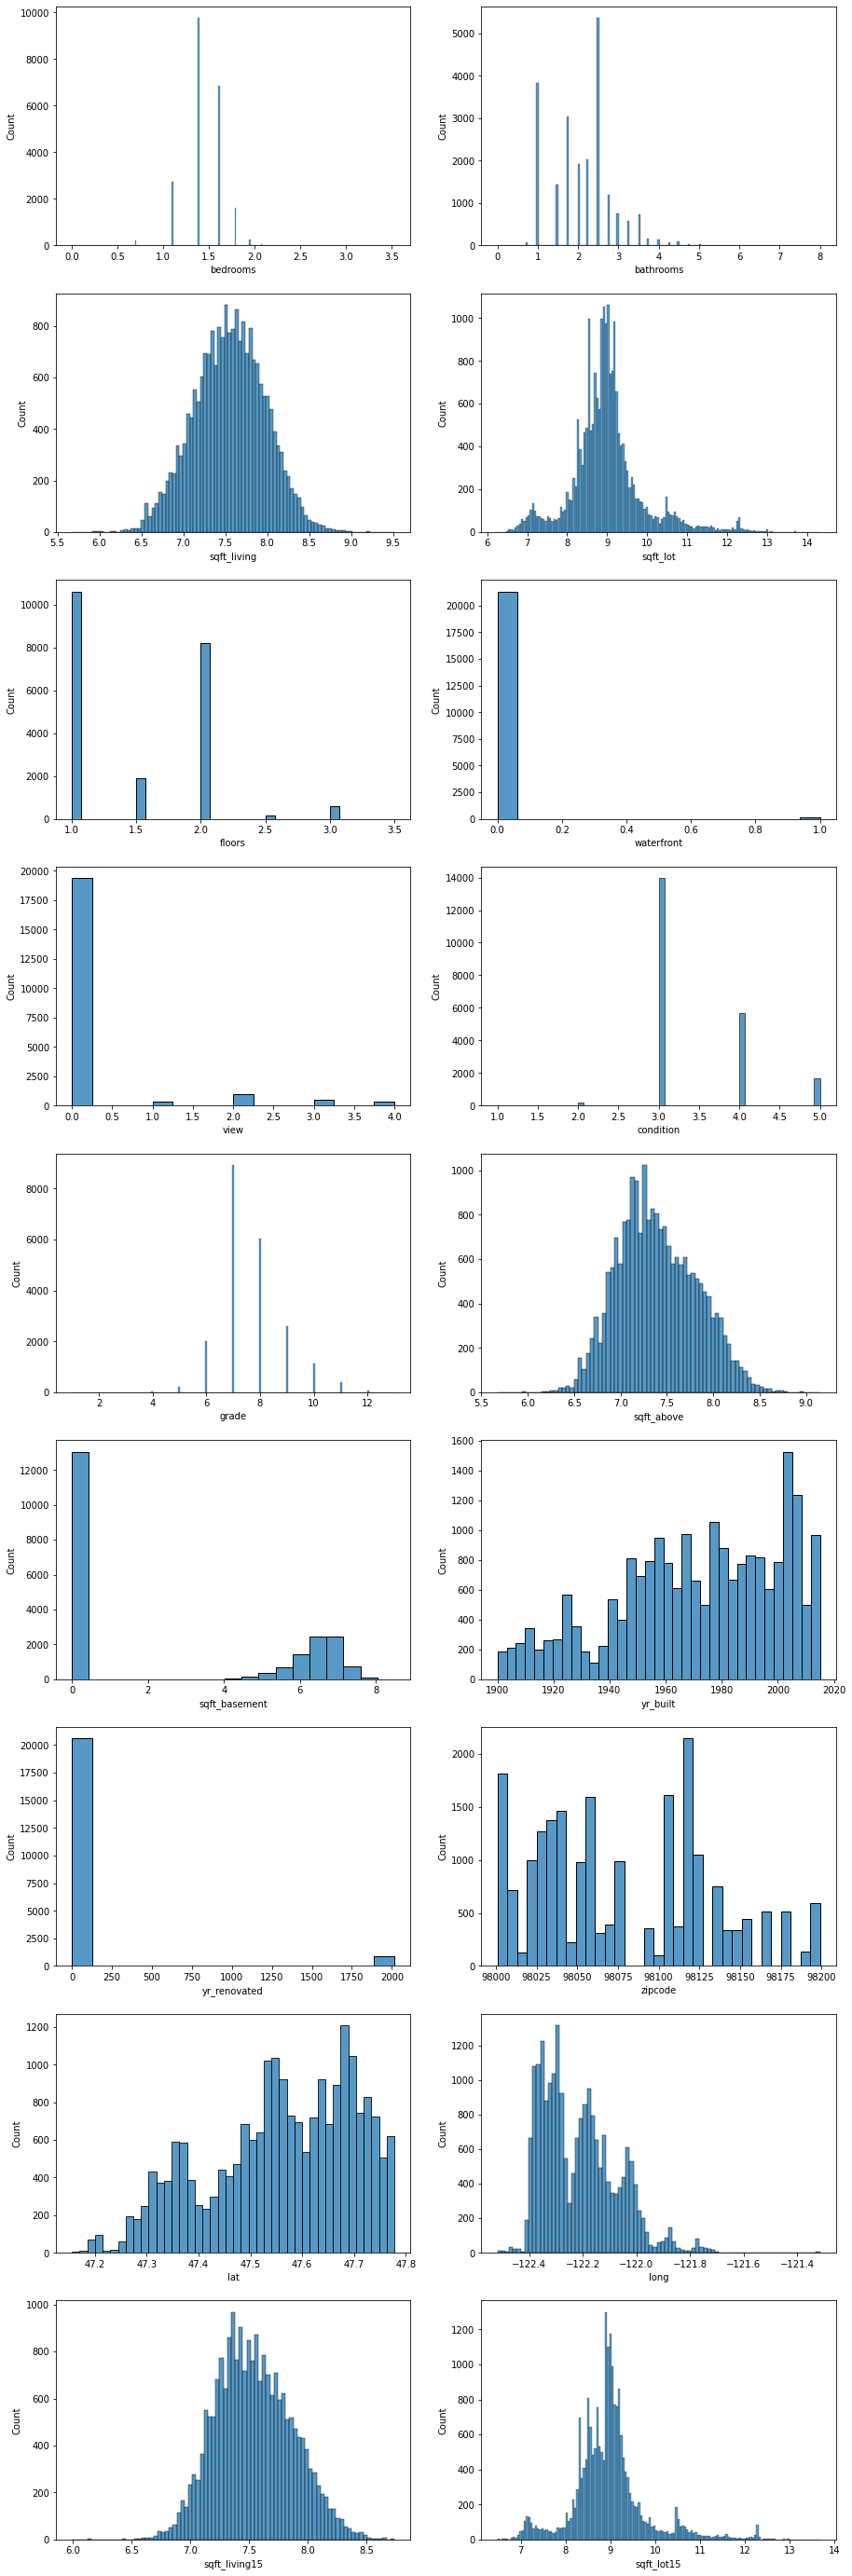

In [40]:
fig, ax = plt.subplots(9, 2, figsize=(15,50))
count = 1


for i in range(9):
    for j in range(2):
        sns.histplot(data=data[data.columns[count]], ax=ax[i][j])
        count +=1
        if count == 19 :
            break

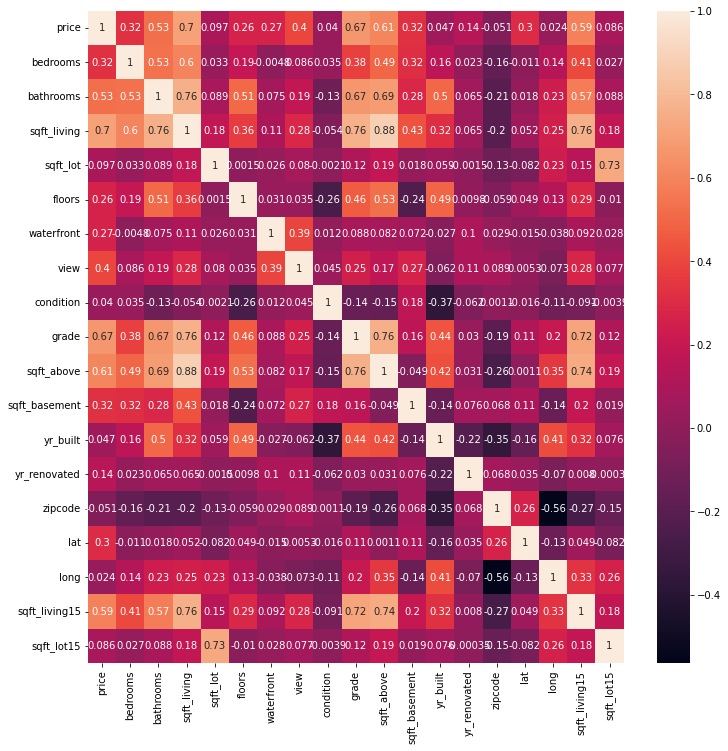

In [117]:
plt.figure(figsize=(12,12))
df = pd.read_csv(join(data_dir, 'train.csv'))
del df['id']
del df['date']

sns.heatmap(df.corr(), annot = True)

plt.show()

 - 상관관계에서 price가 sqft_living, grade, sqft_above, sqft_living15, bathrooms 와 높은 상관관계인 것을 볼수있다

### 변경해야하는 부분 :  id, date의 뒤에 중복되는 0부분 제거 ,  train의 price값 log변환

# Baseline

In [98]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

In [99]:
del train['id']
del test['id']

train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)

y = train['price']
del train['price']

In [100]:
y = np.log1p(y)

### 평가지표
 - 대회의 평가지표가 RMSE이다.

In [86]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
def rmse(y_true, y_pred):
    
    output = np.sqrt(mean_squared_error(y_true, y_pred))
    return output

### 모델 훈련

In [87]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [145]:
random_state=1024

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

- GridSearch함수

In [89]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

 - submission용 파일 저장 함수


In [90]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [121]:
# 스코어 계산 함수
def get_scores(models, train, y):
        df = {}

        for model in models:
            model_name = model.__class__.__name__
            X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if model_name in df:
                model_name = model_name + str(models.index(model))
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
        return (score_df)  

 - lightgbm의 하이퍼 파라미터 조정 GridSearch로 RMSLE이 가장 낮은 하이퍼 파라미터 계수 찾기

In [8]:
param_grid = {
    'learning_rate' : [0.05, 0.1],
    'num_iterations': [1000, 3000],
    'max_depth': [1, 5, 10],
}

my_GridSearch(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

learning_rate=0.05, max_depth=10, num_iterations=1000 일때 RMSLE가 가장 낮음

In [101]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, num_iterations=1000, random_state=random_state)

In [7]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161028')

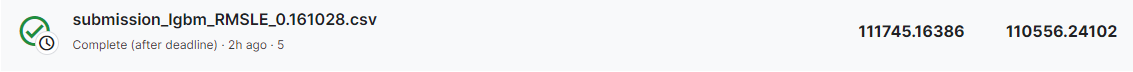<br/>
아직 110000이하로는 나오지 않았다.

 - 부스팅 방법을 기본값인 gbdt가 아닌 dart를 사용하면 어떨까 생각해서 보기로 하였다.
 
 DART : 정확도가 중요할때 쓰이는데, DART는 소소한 부분에 적합한 트리 작성을 억제하고자 신경망에서 사용되는 드롭아웃을 적용하는 방법이다. 결정 트리를 작성할 때마다 드롭아웃 방법처럼 일정 비율의 트리가 존재하지 않는 셈 치고 학습시킨다.

In [6]:
param_grid = {
    'learning_rate' : [0.05, 0.1],
    'num_iterations': [1000, 3000],
    'max_depth': [1, 5, 10],
    'boosting' : ['dart']
}

my_GridSearch(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

In [109]:
model = LGBMRegressor(boosting='dart', learning_rate=0.1, max_depth=10, num_iterations=3000, random_state=random_state)

In [110]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.166948')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.166948.csv saved!


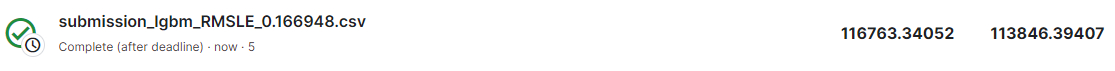
오히려 점수가 더 안좋게 나왔다

 - 하이퍼 파라미터 조정을 그리드 서치가 아닌 베이지안 최적화로 진행해본다.
 
 베이지안 최적화는 미지의 목적함수(blank-box function)을 최대화 혹은 최소화하는 최적해를 찾는 기법이다. Surrogate model(대체모델)과 Acquisition function으로 구성되어 있다.
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbwX24x%2Fbtq9juzlnwb%2FxKkfGF8ktWCjcyFOdB468k%2Fimg.png" width="300" height="300"/>
 t=2, t-3, t=4 이렇게 순차적으로 수행하는데 베이지안 최적화는 그리드서치나 랜덤서치와 달리 사전분포를 활용한다. 사전 분포를 이용하면 보다 더 나은 성능을 도출하는 하이퍼파라미터를 찾을 수 있다.

In [20]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate
from bayes_opt import BayesianOptimization

In [35]:
def xgb_eval(learning_rate, num_iterations, max_depth, output = 'score'):
    params = {
        # 호출 시, 실수형 값들이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경해줘야 함
        'learning_rate': learning_rate,
        'num_iterations' : int(round(num_iterations)),
        'max_depth': int(round(max_depth))
    }
    
    xgb = LGBMRegressor(**params, random_state = 32)
    
    # Cross Validation
    neg_mse_scores = cross_val_score(xgb, train, y,
                                     scoring = 'neg_mean_squared_error',
                                     cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    mean_rmse = np.mean(rmse_scores)
    
    return -mean_rmse # BayesianOptimization의 maximize()를 사용하기 위해, RMSE 값을 음수로 반환

In [36]:
param_grid = {
    'learning_rate' : (0.01,0.1),
    'num_iterations': (1000, 3000),
    'max_depth': (1, 10)
}

In [37]:
# 베이지안 최적화
model_bayes = BayesianOptimization(f = xgb_eval, pbounds = param_grid, random_state = 32)

In [5]:
# 목적 함수가 최대가 되는 최적해를 찾기
model_bayes.maximize(init_points = 5, n_iter = 25)

In [39]:
model_bayes.max

{'target': -0.1606112288402337,
 'params': {'learning_rate': 0.03419802252151553,
  'max_depth': 7.669562699326649,
  'num_iterations': 1000.0689549418126}}

In [43]:
model = LGBMRegressor(learning_rate=model_bayes.max['params']['learning_rate'],
                               num_iterations = int(round(model_bayes.max['params']['num_iterations'])),
                               max_depth = int(round(model_bayes.max['params']['max_depth']))
                               )

In [46]:
save_submission(model, train, y, test, 'lgbm', rmsle='11')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_11.csv saved!


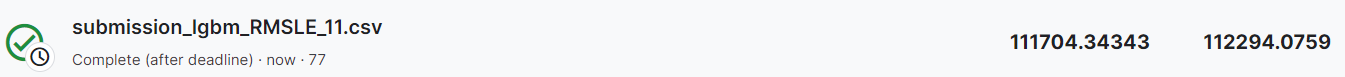
여전히 점수가 개선이 되지 않는다.

### 추가 EDA
#### 상관관계 수치
qft_living, sqft_living15 = 0.76
price, sqft_living = 0.7
price, sqft_living15 = 0.59
sqft_living, sqft_living15가 중복된다고 판단되며 sqft_living가 price와 상관관계가 높기에 sqft_living15를 제거한다.<br/>

sqft_lot, sqft_lot15 = 0.73
price , sqft_lot = 0.097
price, sqft_lot15 = 0.086
price와 sqft_lot,sqft_lot15 서로의 상관관계는 낮지만 두개의 상관관계는
0.73으로 높은 편이기에 price와 상관관계가 더 낮은 sqft_lot15를 제거한다.<br/>

sqft_living, sqft_above = 0.88
grade, sqft_living = 0.76
grade , sqft_above = 0.76
price, sqft_living = 0.7
price, sqft_above = 0.61
price, grade = 0.67
sqft_living와 sqft_above의 상관관계가 0.88로 높으며 내용이 비슷하다고 판단되며 둘다 grade와 높은 상관관계를 보이고 있다.<br/>
또한 grade의 수치인 King County grading 주택 시스템에서는  지하실을 제외한 평방 피트를 고려하여 등급을 매긴다<br/>
price와 비교해 보았을 때 sqft_above의 상관관계가 가장 낮기에 제거해본다.

 - sqft_living15, sqft_lot15, sqft_above 제거하고 진행
 
※ 위와 같이 진행했을 때 점수가 원하는 기준에 나오질 않아 근거가 가장 있는 sqft_above만 제거하고 진행하였다.

In [149]:
train_2 = pd.read_csv(train_data_path)
test_2 = pd.read_csv(sub_data_path)

del train_2['id'], train_2['price']
del test_2['id']

train_2['date'] = train_2['date'].apply(lambda x : str(x[:6])).astype(int)
test_2['date'] = test_2['date'].apply(lambda x : str(x[:6])).astype(int)

In [150]:
del train_2['sqft_above']#,train_2['sqft_living15'], train_2['sqft_lot15']
del test_2['sqft_above']#,test_2['sqft_living15'], test_2['sqft_lot15']

train_2.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
param_grid = {
    'learning_rate' : [0.05, 0.1],
    'num_iterations': [1000, 3000],
    'max_depth': [1, 5, 10],
}

my_GridSearch(lightgbm, train_2, y, param_grid, verbose=2, n_jobs=5)

In [104]:
model = LGBMRegressor(learning_rate=0.05, max_depth=10, num_iterations=1000, random_state=random_state)

In [3]:
save_submission(model, train_2, y, test_2, 'lgbm', rmsle='0.160652')

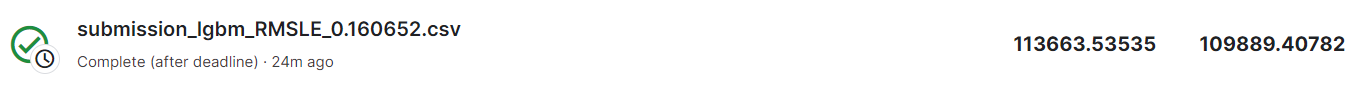
Public Score는 110000이하가 되었지만 Private Score는 아직 아닌것을 확인하였다.<br/>
하나의 모델로는 무리가 있다고 생각되어 voting방법으로 앙상블하여 보겠다.

GBDT (Gradient Boosting Decision Tree)는 모든 데이터 인스턴스를 스캔하여 가능한 모든 분할 지점의 정보 획득을 추정합니다. 따라서 기능 차원이 높고 데이터 크기가 크면 시간이 많이 걸리므로 바람직하지 않습니다. --> 따라서 느립니다.

GOSS (Gradient-based One-Side Sampling)는 GBDT를 더 빠르게 구현한 것으로, 기울기가 작은 데이터 인스턴스의 상당 부분을 제외하고 기울기가 더 큰 인스턴스를 고려하여 정보 이득을 추정합니다. 더 작은 데이터로 매우 정확하고 GBDT보다 확실히 빠를 수 있습니다.

이번엔 기본값인 gbdt가 아닌 goss로 사용해보겠다.<br/>
그리고 하이퍼 파라미터 또한 세분화 해보겠다.

In [2]:
param_grid = {
    'learning_rate' : [0.04, 0.045, 0.05, 0.055, 0.06],
    'num_iterations': [800, 1000, 1200],
    'max_depth': [5, 7, 10, 13, 15],
    'boosting' : ['goss']
}

my_GridSearch(lightgbm, train_2, y, param_grid, verbose=2, n_jobs=5)

In [117]:
model = LGBMRegressor(learning_rate=0.04, max_depth=10, num_iterations=800, boosting = 'goss', random_state=random_state)

In [133]:
param_grid = {
    'learning_rate' : (0.01,0.1),
    'num_iterations': (1000, 3000),
    'max_depth': (1, 10),
}

In [136]:
def xgb_eval(learning_rate, num_iterations, max_depth, output = 'score'):
    params = {
        # 호출 시, 실수형 값들이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경해줘야 함
        'learning_rate': learning_rate,
        'num_iterations' : int(round(num_iterations)),
        'max_depth': int(round(max_depth))
    }
    
    xgb = LGBMRegressor(**params, boosting = 'goss', random_state = 32)
    
    # Cross Validation
    neg_mse_scores = cross_val_score(xgb, train_2, y,
                                     scoring = 'neg_mean_squared_error',
                                     cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    mean_rmse = np.mean(rmse_scores)
    
    return -mean_rmse # BayesianOptimization의 maximize()를 사용하기 위해, RMSE 값을 음수로 반환

In [1]:
# 베이지안 최적화
model_bayes = BayesianOptimization(f = xgb_eval, pbounds = param_grid, random_state = 32)
model_bayes.maximize(init_points = 5, n_iter = 25)

In [138]:
model_bayes.max

{'target': -0.15994366894577175,
 'params': {'learning_rate': 0.016654084136908567,
  'max_depth': 9.576787586738646,
  'num_iterations': 2141.028219351565}}

In [110]:
model = LGBMRegressor(learning_rate=model_bayes.max['params']['learning_rate'],
                               num_iterations = int(round(model_bayes.max['params']['num_iterations'])),
                               max_depth = int(round(model_bayes.max['params']['max_depth']))
                               )

In [111]:
save_submission(model, train_2, y, test_2, 'lgbm', rmsle='321')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_321.csv saved!


In [151]:
from sklearn.ensemble import VotingRegressor

model_xgb = XGBRegressor(learning_rate=0.024, max_depth=8, n_estimators=1000, random_state=random_state)
model_lgbm1 = LGBMRegressor(learning_rate=0.019, max_depth=7, n_estimators=2200, random_state=random_state)
model_lgbm2 = LGBMRegressor(learning_rate=0.05, max_depth=10, num_iterations=1000, random_state=random_state)
model_lgbm3 = LGBMRegressor(learning_rate=0.04, max_depth=10, num_iterations=800, boosting = 'goss', random_state=random_state)
model_lgbm4 = LGBMRegressor(learning_rate=model_bayes.max['params']['learning_rate'],
                               num_iterations = int(round(model_bayes.max['params']['num_iterations'])),
                               max_depth = int(round(model_bayes.max['params']['max_depth'])),
                            boosting = 'goss'
                               )
vote = VotingRegressor(estimators=[('model_xgb', model_xgb), ('model_lgbm1', model_lgbm1), ('model_lgbm2', model_lgbm2), ('model_lgbm3', model_lgbm3),('model_lgbm4', model_lgbm4)])

 - 위에서 하이퍼 파라미터 서칭을 GridSearch와 베이지안 최적화를 이용하여 찾았으며,XGBRegressor 1개, LGBMRegressor의 boosting의 기본값인 gbdt로 2개, goss로 2개 총 5개의 모델을 Voting 방법으로 만들었습니다.


In [152]:
get_scores([model_xgb, model_lgbm1, model_lgbm2, model_lgbm3, model_lgbm4, vote], train_2, y)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


,RMSE
LGBMRegressor3,0.160300
LGBMRegressor2,0.159900
XGBRegressor,0.159480
LGBMRegressor,0.158613
LGBMRegressor4,0.158519
VotingRegressor,0.156797


In [153]:
save_submission(vote, train_2, y, test_2, "voting", 0.156797)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_voting_RMSLE_0.156797.csv saved!


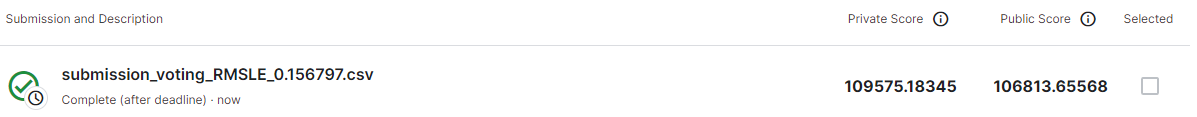
### 최종      Private Score : 109575.18345         Public Score : 106813.65568

## 회고

- 이런 대회를 직접 해본적은 처음이었기에 노드를 따라 진행하였지만 내가 자율적으로 성능을 좋게하기 위해서 어떠한 것이 필요한지에 대한 부분이 어색하여 많이 버벅되었다.
- 위 대회를 진행하면서 앙상블 학습부터 랜덤 포레스트, XGBoost, LightGBM등 모델을 공부해보았고 실제로 사용하면서 알 수 있었다.
- 데이터 전처리(EDA) 부분도 데이터 시각화와 시각화한 데이터에서 인사이트를 찾고 추가적인 작업하는 부분이 어색하였고 힘들었지만 단지 이론으로만 보는 것 보다 사용하면서 부딪히니 생각보다 괜찮았다.
- 처음에는 데이터를 추가적으로 제거나 전처리하지 않고 해보려했으나 점수가 좋지 않았기에 필요성을 느꼈다.
- 모델또한 단일 모델로 해보려 했으나 점수가 좋지 않았기에 여러 시도를 해보게되었다.